### Setup

In [1]:
import sys
# Python 3.7 is required
assert sys.version_info >= (3,7)

import cv2 as cv
import numpy as np
from util_func import *

## Question 1
Write a program to segment the boat and the people on it from the background. Follow the instruction below:
- Use 'boat.jpg' as input.
- Apply Otsu thresholding.
- Draw bounding box to identify the region where the boat and people are located.

In [2]:
# Load the image
image = cv.imread('images/boat.jpg', cv.IMREAD_COLOR)

# Convert the image to grayscale
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Apply OTSU thresholding
_, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)

# Find contours in the thresholded image
contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Define a minimum area threshold for contour filtering
min_area = 2000

# Iterate through the contours and draw bounding boxes
for contour in contours:
    area = cv.contourArea(contour)
    if area > min_area:
        x, y, w, h = cv.boundingRect(contour)
        cv.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the result
cv.imshow('Segmented Image', image)
cv.waitKey(0)
cv.destroyAllWindows()

## Question 2
Write a program to visualize the effect of size of structuring element on the morphological transformation (e.g. erosion, dilation, opening, and closing).

- Load the 'leaf.jfif' and perform thresholding to segment the leaf from the background.
- Create a GUI containing trackbar to control the size of structuring element and display the resulting image on a window alongside the trackbar.

In [4]:
def apply_morphology(img, operation, size):
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (size, size))
    
    if operation == 'erosion':
        result = cv.erode(img, kernel, iterations=1)
    elif operation == 'dilation':
        result = cv.dilate(img, kernel, iterations=1)
    elif operation == 'opening':
        result = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
    elif operation == 'closing':
        result = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)
    else:
        result = img
    
    return result

def on_trackbar_change(val):
    size = cv.getTrackbarPos('Size', 'Morphological Transformation')
    
    if size % 2 == 0:
        size += 1
    
    transformed_image = apply_morphology(binary_image, selected_operation, size)
    cv.imshow('Morphological Transformation', transformed_image)
    
# Load the image
image_path = 'images/leaf.jfif'
image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

# Perform thresholding to segment the leaf from the background
_, binary_image = cv.threshold(image, 128, 255, cv.THRESH_BINARY)

# Create a GUI window with trackbar
cv.namedWindow('Morphological Transformation')
cv.createTrackbar('Size', 'Morphological Transformation', 3, 21, on_trackbar_change)

operations = ['erosion', 'dilation', 'opening', 'closing']
selected_operation = operations[0]

print("Press 'e' for erosion, 'd' for dilation, 'o' for opening, 'c' for closing")

# Initialize with the first operation
on_trackbar_change(0)

while True:
    key = cv.waitKey(0) & 0xFF
    
    if key == ord('e'):
        selected_operation = 'erosion'
        on_trackbar_change(0)
    elif key == ord('d'):
        selected_operation = 'dilation'
        on_trackbar_change(0)
    elif key == ord('o'):
        selected_operation = 'opening'
        on_trackbar_change(0)
    elif key == ord('c'):
        selected_operation = 'closing'
        on_trackbar_change(0)
    elif key == 27:  # Press Esc to exit
        break

cv.destroyAllWindows()

Press 'e' for erosion, 'd' for dilation, 'o' for opening, 'c' for closing


## Question 3
Apply the steps shown in exercise 4 to segment the porcelain from these images: "porcelain1.jfif" - "porcelain5.jfif".

In [5]:
img = cv.imread('images/color_space/porcelain1.jfif')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

In [6]:
#visualize the pixels on a 3D plot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

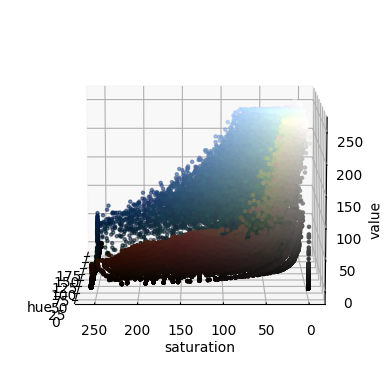

In [7]:
# Hsv 
img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

h, s, v = cv.split(img_hsv)
fig = plt.figure()
axis = fig.add_subplot(1,1,1,projection="3d")

pixel_colors = img.reshape((img.shape[0]*img.shape[1], 3))
norm = colors.Normalize()
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(h.ravel(), s.ravel(), v.ravel(),
            facecolors = pixel_colors, marker=".")
axis.view_init(elev=10,azim=180)
axis.set_xlabel("hue")
axis.set_ylabel("saturation")
axis.set_zlabel("value")
plt.show()

In [8]:
blue_low = (85,90,0)
blue_high = (125,255,160)

white_low = (0, 0, 100)
white_high = (255, 50, 255)

mask_blue = cv.inRange(img_hsv, blue_low, blue_high)
mask_white = cv.inRange(img_hsv, white_low, white_high)
combined_mask = cv.bitwise_or(mask_blue, mask_white)

kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))
cleaned_mask = cv.morphologyEx(combined_mask, cv.MORPH_CLOSE, kernel)
segmented_porcelain = cv.bitwise_and(img, img, mask=cleaned_mask)

color_range = [(blue_low, blue_high), (white_low, white_high)]

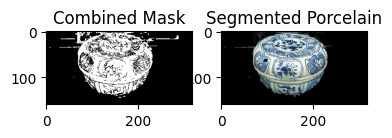

In [9]:
# color segmentation
plt.subplot(132), plt.imshow(combined_mask, cmap='gray'), plt.title("Combined Mask")
plt.subplot(133), plt.imshow(segmented_porcelain), plt.title("Segmented Porcelain")
plt.show()

In [10]:
# define color segmentation function
def color_seg(img,color_range, smooth=True):
    """Args:
    img: src img RGB,
    color_low and color_high are tuples of color in HSV,
    smooth: boolean which control whether image will be blurred"""
    img_ori = img.copy()
    if smooth:
        img = cv.GaussianBlur(img,(5,5),0)
        
    #change color space
    img_hsv = cv.cvtColor(img,cv.COLOR_RGB2HSV)

    combined_mask = np.zeros(img.shape[:2], dtype=np.uint8)
    
    for color_low, color_high in color_range:
        mask = cv.inRange(img_hsv, color_low, color_high)
        mask = cv.erode(mask, None, iterations=2)
        mask = cv.dilate(mask, None, iterations=2)
        combined_mask = cv.bitwise_or(combined_mask, mask)
    
    return cv.bitwise_and(img_ori, img_ori, mask=combined_mask)

imgs = []
for i in range(1,6):
    img = cv.imread(cv.samples.findFile(f"images/color_space/porcelain{i}.jfif"))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    imgs.append(img)

res_combined = [color_seg(im, color_range) for im in imgs]

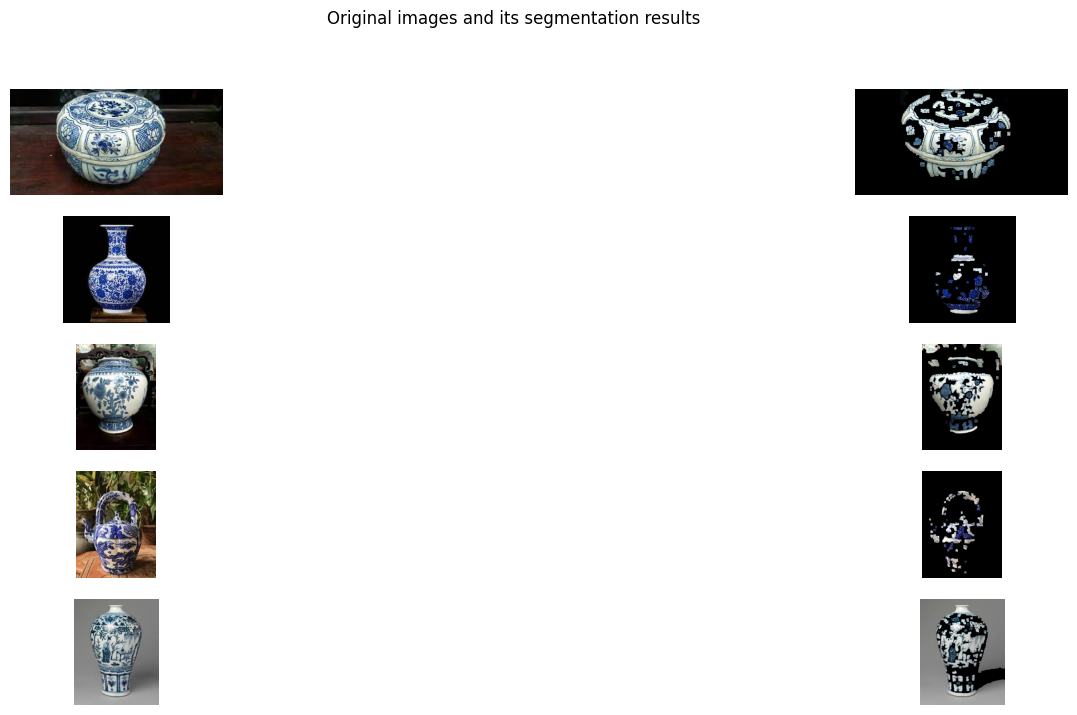

In [11]:
fig, ax = plt.subplots(5,2,figsize=(20,8))

for i in range(5):
    ax[i][0].imshow(imgs[i])
    ax[i][0].axis("off")
    ax[i][1].imshow(res_combined[i])
    ax[i][1].axis("off")
    
fig.suptitle("Original images and its segmentation results")
plt.tight_layout
plt.show()